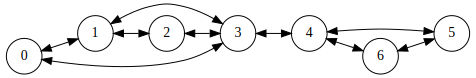

In [194]:
from pygraphblas import  *
from pygraphblas.gviz import *

# example graph from figure 2 in paper

a = 0
b = 1
c = 2
V = 3
d = 4
e = 5
f = 6


A = Matrix.from_lists(
    [a, a, b, b, c, d, d, d, e],
    [b, V, c, V, V, V, e, f, f],
    [1.0] * 9, 7, 7
)

A = A + A.T # make symmetric
draw(A, show_weight=False)

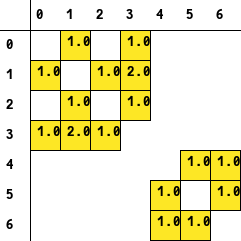

In [198]:
I = Matrix.identity(A.type, A.nrows)
v1 = Vector.dense(A.type, A.nrows, 1.0) # iso

T = A.mxm(A, mask=A)

draw_matrix(T, axes_labels=True, scale=30)

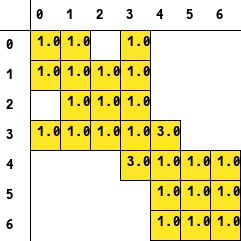

In [196]:
That = T.pattern(A.type)

X = ((3 * A) - (2 * That) + I)

gb.gviz.draw_matrix(X, axes_labels=True, scale=30)

In [200]:
y = T @ v1
k = v1 @ y  # inner vector product?

C = (1/k) @ X @ y




AttributeError: 'Vector' object has no attribute 'ncols'